In [22]:
import requests
import json 
import sys
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn as sk
import test_utils_models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
url = 'http://localhost:8000/sequenceset_manager/get_sequence_data'

features = ['pctChgclose', 'pctChgvolume', 'pctDiff+ema50_close', 'pctDiff+ema100_close',
'pctDiff+ema200_close', 'pctDiff+smaVol10_volume', 'pctDiff+smaVol20_volume',
'pctDiff+bb_high_close10', 'pctDiff+bb_low_close10', 'rsi10', 'rsi20',
'opHi', 'opCl', 'pctChgClOp', 'macd_signal']

target_features = ['pctChgclose+{}'.format(i) for i in range(1, 16) ]


indices_seq = list(range(len(features + target_features)))

feature_dict = {col: index for col, index in zip(features+target_features, indices_seq)}


In [3]:
tickers = ['AAPL', 'SPY', "QQQ"]

In [4]:
all_sequences = []
for ticker in tickers:
    params = {
        'ticker': ticker,
        'features': features + target_features,
        'interval': '1d',
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        try:
            data = response.json()
            all_sequences.append(data)
        except json.JSONDecodeError as e:
            print(f"Failed to decode JSON: {e}")
            print("Response text:", response.text)
    else:
        print(f"Request failed with status code {response.status_code}")

In [5]:
print(len(all_sequences))

3


In [6]:
def create_3d_array(stock_sequences):
    # Create a 3D array to store the sequences
    # The array will have the shape (num_sequences, sequence_length, num_features)
    # stock sequences is a list of sequence_dicts where each sequence_dict is a dictionary 
    # we are extracting 'sliced_data' from each sequence_dict and creating 3d np array

    num_sequences = len(stock_sequences)
    sequence_length = len(stock_sequences[0]['sliced_data'])
    num_features = len(features)
    X = np.zeros((num_sequences, sequence_length, num_features))
    y = np.zeros((num_sequences, len(target_features)))
    for i, sequence_dict in enumerate(stock_sequences):
        X_cols = [feature_dict[col] for col in features]
        y_cols = [feature_dict[col] for col in target_features]

        X[i, :, :] = np.array(sequence_dict['sliced_data'])[:, X_cols]
        y[i, :] = np.array(sequence_dict['sliced_data'])[-1, y_cols]


    return X, y

In [12]:
def preprocess_multi_stock(all_sequences, test_size=0.2):
    X_train = None
    X_test = None
    y_train = None
    y_test = None
    for sequences in all_sequences:
        print(len(sequences))
        X, y = create_3d_array(sequences)

        for i in range(len(X)-1, 0, -1):
            if np.isnan(y[i]).any():
                X = np.delete(X, i, axis=0)
                y = np.delete(y, i, axis=0)
        
        X_train_cur, X_test_cur, y_train_cur, y_test_cur = train_test_split(X, y, test_size=test_size, random_state=42)

        if X_train is None:
            X_train = X_train_cur
            X_test = X_test_cur
            y_train = y_train_cur
            y_test = y_test_cur
        else:
            X_train = np.vstack((X_train, X_train_cur))
            X_test = np.vstack((X_test, X_test_cur))
            y_train = np.vstack((y_train, y_train_cur))
            y_test = np.vstack((y_test, y_test_cur))
    
    return X_train, X_test, y_train, y_test


In [13]:
X_train, X_test, y_train, y_test = preprocess_multi_stock(all_sequences)

10966
7899
6357


In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20140, 50, 15) (5037, 50, 15) (20140, 15) (5037, 15)


In [15]:
size_in_bytes = X_train.nbytes
size_in_mb = size_in_bytes / 1024 / 1024
size_in_gb = size_in_mb / 1024
print(f"Size of the array in memory: {size_in_gb:.2f} gb")

Size of the array in memory: 0.11 gb


In [16]:
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_scaler = sk.preprocessing.StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

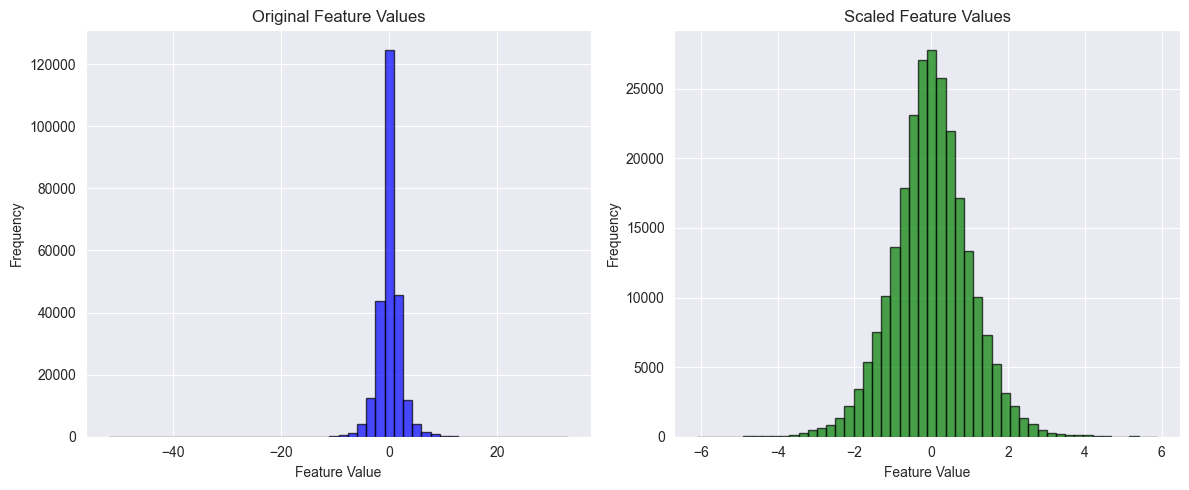

In [17]:
feature_values_test = X_test[:, :, 0]
feature_values_test_scaled = X_test_scaled[:, :, 0]

flattened_values_test = feature_values_test.flatten()
flattened_values_test_scaled = feature_values_test_scaled.flatten()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the original feature values
axes[0].hist(flattened_values_test, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title('Original Feature Values')
axes[0].set_xlabel('Feature Value')
axes[0].set_ylabel('Frequency')

# Plot the scaled feature values
axes[1].hist(flattened_values_test_scaled, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].set_title('Scaled Feature Values')
axes[1].set_xlabel('Feature Value')
axes[1].set_ylabel('Frequency')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [19]:
y_train_scaled = np.expand_dims(y_train_scaled, axis=-1)
y_test_scaled = np.expand_dims(y_test_scaled, axis=-1)

In [28]:
baseline_model = test_utils_models.CustomSeq2SeqModel(len(target_features), X_train_scaled.shape[1], X_train_scaled.shape[2])

In [29]:
lr = 0.001
batch_size = 64
epochs = 250

loss = 'mse'

baseline_model.compile(optimizer = Adam(learning_rate=lr), loss = loss)

In [ ]:
baseline_model.fit(X_train_scaled, y_train_scaled,
                   validation_data=(X_test_scaled, y_test_scaled),
                   batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/250
(None, 50, 63)
decoder outputs
(None, 15, 1)
decoder outputs
(None, 15, 1)
(None, 50, 63)
decoder outputs
(None, 15, 1)
(None, 50, 63)
decoder outputs
(None, 15, 1)
(None, 50, 63)
decoder outputs
(None, 15, 1)
Attention Weights Shape:  (None, 15, 50)
315/315 - 13s - 40ms/step - loss: 1.0794 - val_loss: 0.9989
Epoch 2/250
315/315 - 11s - 34ms/step - loss: 0.9999 - val_loss: 0.9978
Epoch 3/250
315/315 - 11s - 34ms/step - loss: 0.9991 - val_loss: 0.9972
Epoch 4/250
315/315 - 11s - 34ms/step - loss: 0.9984 - val_loss: 0.9956
Epoch 5/250
315/315 - 11s - 34ms/step - loss: 0.9978 - val_loss: 0.9950
Epoch 6/250
